In [8]:
import pandas as pd # 引用套件並縮寫為 pd  
df_capterra = pd.read_csv('ZoomMeetings.csv', encoding='utf_8_sig', index_col=0) 
df_capterra

,Title,Overall,Pros,Cons,Switch,Switch_reason,Alter,Alter_reason
Review,,,,,,,,
1,“The Perfect Home Office Companion!”,I have been using Zoom for a long time now. Bu...,Zoom is undoubtedly the best meeting software ...,Zoom certainly offers a nice free plan with ma...,Google Meet,While the UI of Google Meet is very simple and...,NaN,While looking for the best video conferencing ...
2,“Critical for people with ADHD”,NaN,There are lots of things that are helpful abou...,There are too many clicks needed to do anythin...,Google Hangouts,"Video quality is better in zoom, and Google Ha...",NaN,NaN
3,“Effective but Buggy!”,Works well but can always be improved technolo...,I love how common it is and how popular many p...,"I think overall bugs, audio drop outs, and con...",SkypeTime,Was too hard to use,Webex,Zoom is just user friendly
4,“I bet you never heard about Zoom before the p...,"I never heard of Zoom before the pandemic, act...",Zoom is great for online meetings. Whether you...,"Zoom can be very confusing for older people, t...",Google Meet,"Meet has some limitations, like no private cha...",NaN,NaN
5,“Zoom: a classic and intuitive video conferenc...,"Large conference calls with many, even hundred...",Zoom has a simple and intuitive operation and ...,The audio quality copes well with briefly slow...,NaN,NaN,Microsoft Teams,"The usability is remarkable and intuitive, eve..."
...,...,...,...,...,...,...,...,...
2996,“Great for connecting with Customers”,NaN,I use this regularly to talk to my clients and...,That I had to download an app on my phone to r...,NaN,I just found the calls were better with Zoom,NaN,NaN
2997,“Zoom for Communication”,I enjoy it as it makes meeting with another pe...,I enjoyed the feature of seeing the other pers...,Sometimes it can be difficult to hear the othe...,NaN,Zoom was more user friendly and worked better.,NaN,NaN
2998,"“Work fine, although some important settings a...","We work it everyday, and for weeks it didn't f...",It easy to setup and join the meeting and the ...,Some important settings are buried in the adva...,Google Meet,We needed more reliable tool.,NaN,NaN


In [9]:
doc_complete = df_capterra.Cons.values.tolist()
doc_complete[0]

"Zoom certainly offers a nice free plan with many features. But I don't really like the time limit thing in the free version. Rather they could have just restricted a few features from here and there. It would help many people who can't afford self-hosting zoom or buying a premium plan. But I must admit that the paid plan is not that expensive."

In [10]:
# Convert to list
doc_complete = df_capterra.Cons.values.tolist()
doc_seperate=[]
import re
for review in doc_complete:
    pattern = r'.'
    review = str(review)
    result = review.split('.')
    for i in result:
        doc_seperate.append(i)
doc_seperate[1]

" But I don't really like the time limit thing in the free version"

In [11]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(doc_seperate))
print(data_words[1])

['but', 'don', 'really', 'like', 'the', 'time', 'limit', 'thing', 'in', 'the', 'free', 'version']


In [12]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['zoom', 'certainly', 'offers', 'nice', 'free', 'plan', 'with', 'many', 'features']


In [13]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['nan', 'subject', 're', 'edu'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# !python -m spacy download en

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN'])

print(data_lemmatized[8])

['change', 'wish', 'click']


In [15]:
from gensim import corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


### LDA 法一

In [9]:
from gensim.models import CoherenceModel
# Build LDA model
import matplotlib.pyplot as plt
topics_num = []
Coherence_Score = []

for i in range(1,21):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=i, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    topics_num.append(i)
    Coherence_Score.append(coherence_lda)

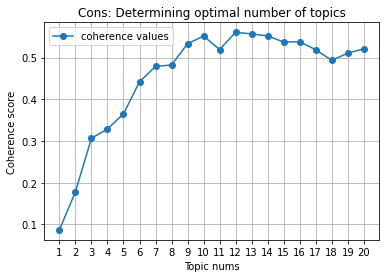

In [10]:
lines = plt.plot(topics_num, Coherence_Score)
plt.setp(lines, marker = "o") 
plt.grid(True)
plt.title("Cons: Determining optimal number of topics") 
plt.xlabel("Topic nums")
plt.ylabel("Coherence score")
plt.legend(["coherence values"], loc='best')
plt.xticks(topics_num)
plt.show()

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.327*"meeting" + 0.279*"zoom" + 0.041*"host" + 0.021*"company" + '
  '0.017*"number" + 0.014*"join" + 0.014*"dislike" + 0.013*"couple" + '
  '0.011*"plan" + 0.011*"limitation"'),
 (1,
  '0.122*"experience" + 0.093*"service" + 0.065*"datum" + 0.055*"face" + '
  '0.039*"invite" + 0.033*"see" + 0.031*"news" + 0.030*"list" + '
  '0.028*"conversation" + 0.023*"world"'),
 (2,
  '0.174*"people" + 0.068*"participant" + 0.060*"con" + 0.057*"product" + '
  '0.050*"room" + 0.041*"platform" + 0.039*"button" + 0.038*"file" + '
  '0.032*"name" + 0.025*"conferencing"'),
 (3,
  '0.244*"user" + 0.080*"setting" + 0.063*"link" + 0.062*"interface" + '
  '0.051*"access" + 0.045*"device" + 0.045*"network" + 0.033*"ability" + '
  '0.030*"volume" + 0.029*"document"'),
 (4,
  '0.156*"software" + 0.138*"use" + 0.127*"feature" + 0.072*"option" + '
  '0.061*"lot" + 0.036*"account" + 0.022*"package" + 0.021*"day" + '
  '0.021*"price" + 0.019*"browser"'),
 (5,
  '0.127*"application" + 0.102*"window" + 0.06

In [11]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.2714578371924

Coherence Score:  0.5606491663169257


In [12]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.278052 -0.322419       1        1  17.933578
11    -0.270800  0.326326       2        1  15.483271
4     -0.089871  0.004111       3        1  13.170206
2      0.032878 -0.000035       4        1  10.224255
9     -0.022090  0.000850       5        1   9.872978
7      0.027544 -0.000271       6        1   8.517855
10     0.065002 -0.000975       7        1   6.843740
3      0.083731 -0.001177       8        1   5.823891
5      0.104832 -0.001801       9        1   4.416822
6      0.112788 -0.001561      10        1   3.039865
8      0.116420 -0.001538      11        1   2.392196
1      0.117617 -0.001510      12        1   2.281342, topic_info=          Term         Freq        Total Category  logprob  loglift
13     meeting  1522.000000  1522.000000  Default  30.0000  30.0000
2         zoom  1300.000000  1300.000000  Default  29.0000  29.0000
5         time   928.000000   928.000000  Default  28.0000  28.0000
31       video   578.000000   578.000000  Default  27.0000  27.0000
20       issue   550.000000   550.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
340    country     2.083366     3.091504  Topic12  -5.6501   3.3857
528       line     1.494627     2.502771  Topic12  -5.9822   3.2649
456       edit     1.473210     2.481352  Topic12  -5.9967   3.2590
124  developer     1.102822     2.163482  Topic12  -6.2862   3.1066
48     mistake     0.923757     1.931903  Topic12  -6.4634   3.0426

[394 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
473       8  0.981160      ability
136       8  0.985720       access
11        3  0.990719      account
679       2  0.977651     addition
549      12  0.925330  alternative
...     ...       ...          ...
121      10  0.988884         work
895      12  0.905696        world
245       6  0.974704         year
343      11  0.818214      youtube
2         1  0.999137         zoom

[348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 12, 5, 3, 10, 8, 11, 4, 6, 7, 9, 2])

In [18]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each review
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=doc_seperate)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Cons_review_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Cons_review_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.2960,"meeting, zoom, host, company, number, join, di...",Zoom certainly offers a nice free plan with ma...
1,1,11.0,0.4061,"time, screen, thing, bit, version, connection,...",But I don't really like the time limit thing ...
2,2,4.0,0.2175,"software, use, feature, option, lot, account, ...",Rather they could have just restricted a few ...
3,3,0.0,0.3930,"meeting, zoom, host, company, number, join, di...",It would help many people who can't afford se...
4,4,0.0,0.2569,"meeting, zoom, host, company, number, join, di...",But I must admit that the paid plan is not th...
...,...,...,...,...,...
9479,9479,4.0,0.1825,"software, use, feature, option, lot, account, ...",No complaints - I haven't had any issues with ...
9480,9480,0.0,0.1782,"meeting, zoom, host, company, number, join, di...",
9481,9481,11.0,0.2780,"time, screen, thing, bit, version, connection,...","We can't all afford the paid version, so we us..."
9482,9482,11.0,0.1822,"time, screen, thing, bit, version, connection,...",I really dislike that we can only use the roo...


In [19]:
df_dominant_topic[df_dominant_topic["Dominant_Topic"] == 3.0].sort_values(by=['Topic_Perc_Contrib'], ascending=False)

,Cons_review_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
6122,6122,3.0,0.3384,"user, setting, link, interface, access, device...",Each source provides you access to some but n...
9474,9474,3.0,0.2853,"user, setting, link, interface, access, device...",Some important settings are buried in the adva...
1173,1173,3.0,0.2838,"user, setting, link, interface, access, device...",While you can turn of the entry chime when a u...
7467,7467,3.0,0.2767,"user, setting, link, interface, access, device...",What I like least about using Zoom is how unsu...
221,221,3.0,0.2645,"user, setting, link, interface, access, device...",While you can still limit user access to cert...
...,...,...,...,...,...
6162,6162,3.0,0.1765,"user, setting, link, interface, access, device...",Many of the PC options are not in the mobile ...
3462,3462,3.0,0.1765,"user, setting, link, interface, access, device...",I have found that the more users that jump on ...
5157,5157,3.0,0.1651,"user, setting, link, interface, access, device...",There are a lot of backend settings that I kno...
7288,7288,3.0,0.1552,"user, setting, link, interface, access, device...",Inability of some non tech users to access fea...


In [20]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5222,"meeting, zoom, host, company, number, join, di...",Because we use Zoom Meetings for site-wide me...
1,1.0,0.3191,"experience, service, datum, face, invite, see,...",I've actually disabled this plug-in due to it...
2,2.0,0.3720,"people, participant, con, product, room, platf...","Like other commercial products, significant am..."
3,3.0,0.3384,"user, setting, link, interface, access, device...",Each source provides you access to some but n...
4,4.0,0.4169,"software, use, feature, option, lot, account, ...",The thing that i think may be developed in Zoo...
5,5.0,0.3811,"application, window, information, program, end...",I have the problem that i can use the applicat...
6,6.0,0.2639,"work, desktop, update, control, improvement, c...","Virtual backgrounds are not compatible, or it ..."
7,7.0,0.4303,"video, quality, tool, internet_connection, tea...","\nOnce in a while when web speed drops, the so..."
8,8.0,0.2589,"problem, function, fact, integration, usage, s...",Zoom is still fairly rudimentary in its aesthe...
9,9.0,0.3679,"issue, security, call, app, need, client, back...",More transparency on security and servers used...


In [21]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# topic_contribution = topic_contribution.rename_axis('Dominant_Topic').reset_index(name='percentage')

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
topic_num_keywords.index = range(len(topic_num_keywords))

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_contribution, topic_counts], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Perc_eviews', 'Num_Reviews']
df_dominant_topics.sort_values(by=['Dominant_Topic'])

,Dominant_Topic,Topic_Keywords,Perc_eviews,Num_Reviews
0.0,0.0,"meeting, zoom, host, company, number, join, di...",0.5812,5512
7.0,1.0,"experience, service, datum, face, invite, see,...",0.0386,366
8.0,2.0,"people, participant, con, product, room, platf...",0.0014,13
9.0,3.0,"user, setting, link, interface, access, device...",0.0528,501
2.0,4.0,"software, use, feature, option, lot, account, ...",0.0567,538
6.0,5.0,"application, window, information, program, end...",0.0025,24
10.0,6.0,"work, desktop, update, control, improvement, c...",0.0086,82
4.0,7.0,"video, quality, tool, internet_connection, tea...",0.1033,980
11.0,8.0,"problem, function, fact, integration, usage, s...",0.1396,1324
3.0,9.0,"issue, security, call, app, need, client, back...",0.0074,70


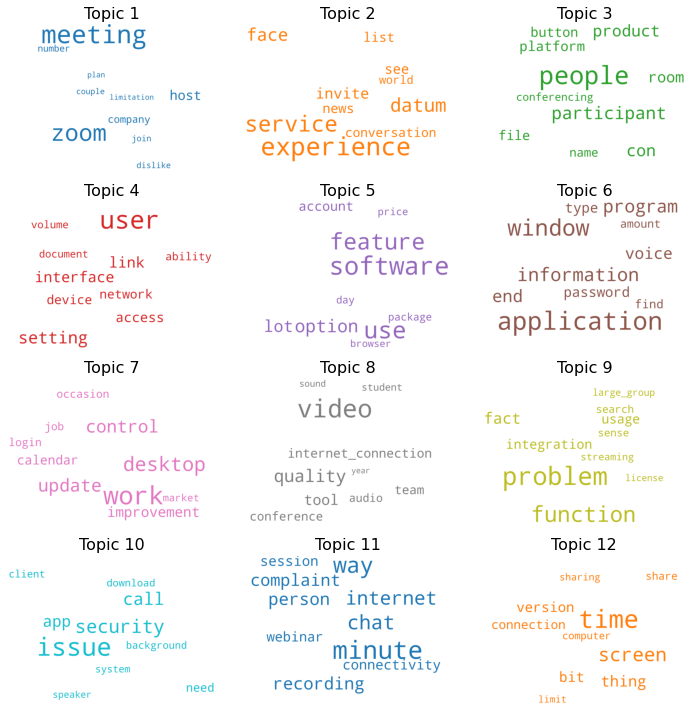

In [15]:
# 1. Wordcloud of Top N words in each topic
import numpy as np
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

color_list = [('tab:blue', '#1f77b4'), ('tab:orange', '#ff7f0e'), ('tab:green', '#2ca02c'), ('tab:red', '#d62728'), ('tab:purple', '#9467bd'), 
 ('tab:brown', '#8c564b'), ('tab:pink', '#e377c2'),  ('tab:gray', '#7f7f7f'), ('tab:olive', '#bcbd22'), ('tab:cyan', '#17becf'), 
 ('tab:blue', '#1f77b4'), ('tab:orange', '#ff7f0e'), ('tab:green', '#2ca02c'), ('tab:red', '#d62728'), ('tab:purple', '#9467bd'), 
 ('tab:brown', '#8c564b'), ('tab:pink', '#e377c2'),  ('tab:gray', '#7f7f7f'), ('tab:olive', '#bcbd22'), ('tab:cyan', '#17becf')]
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in color_list]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_topics=12)
fig, axes = plt.subplots(4, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('Wordcloud_zoom_cons.png')

plt.show()

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False, num_topics=12)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

df
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in color_list]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
#     ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=12)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=18, y=1.05) 

plt.savefig('TopicKeywords_zoom_cons.png')
plt.show()

In [22]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            
# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False, num_topics=12) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)
df_top3words

,topic_id,words
0,0,"meeting, \nzoom, \nhost"
1,1,"experience, \nservice, \ndatum"
2,2,"people, \nparticipant, \ncon"
3,3,"user, \nsetting, \nlink"
4,4,"software, \nuse, \nfeature"
5,5,"application, \nwindow, \ninformation"
6,6,"work, \ndesktop, \nupdate"
7,7,"video, \nquality, \ntool"
8,8,"problem, \nfunction, \nfact"
9,9,"issue, \nsecurity, \ncall"


C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


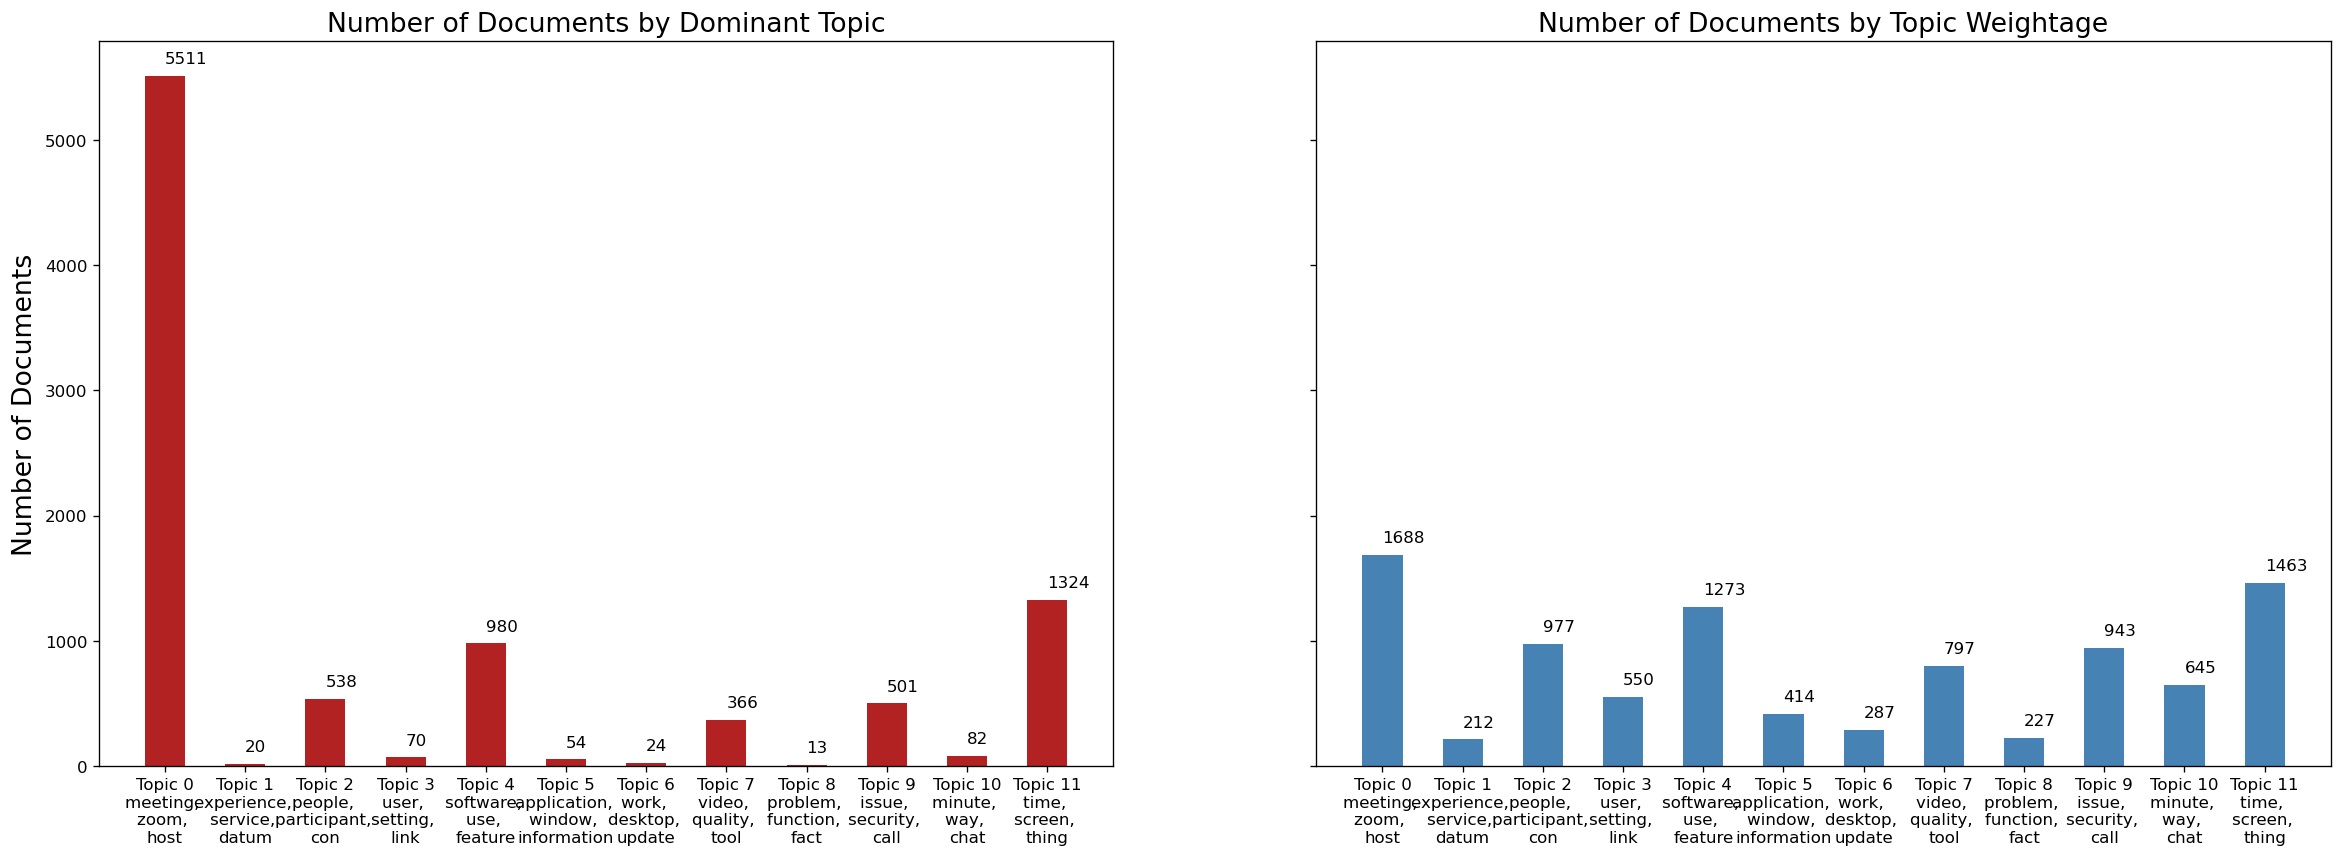

In [20]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
for index,data in enumerate(df_dominant_topic_in_each_doc['count']):
    ax1.text(x=index , y =data+100 , s=int(data) , fontdict=dict(fontsize=10))
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, _: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=16))
ax1.set_ylabel('Number of Documents', fontdict=dict(size=16))

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
for index,data in enumerate(df_topic_weightage_by_doc['count']):
    ax2.text(x=index , y =data+100 , s=int(data) , fontdict=dict(fontsize=10))
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=16))

plt.savefig('Documents_zoom_cons.png')
plt.show()

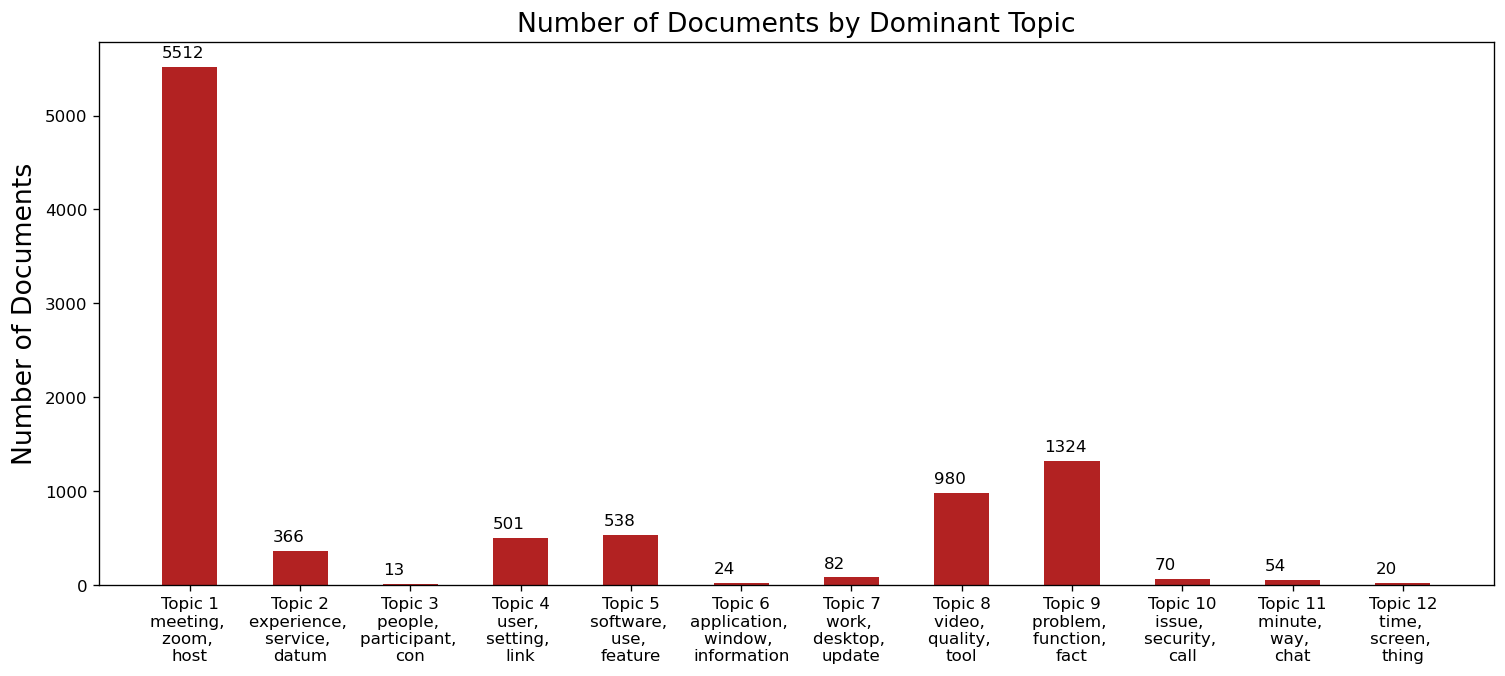

In [24]:
import numpy as np
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()


# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# topic_contribution = topic_contribution.rename_axis('Dominant_Topic').reset_index(name='percentage')

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
topic_num_keywords.index = range(len(topic_num_keywords))

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_contribution, topic_counts], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Perc_eviews', 'Num_Reviews']
df_dominant_topics = df_dominant_topics.sort_values(by=['Dominant_Topic'])


# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6), dpi=120, sharey=True)
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='Num_Reviews', data=df_dominant_topics, width=.5, color='firebrick')
for index,data in enumerate(df_dominant_topics['Num_Reviews']):
    ax1.text(x=index-0.25 , y =data+100 , s=int(data) , fontdict=dict(fontsize=10))
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, _: 'Topic ' + str(x+1)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=16))
ax1.set_ylabel('Number of Documents', fontdict=dict(size=16))
plt.savefig('Documents_zoom_cons.png')
plt.show()

### LDA 法二

In [129]:
from gensim.models import LdaMulticore
# Build LDA model
import matplotlib.pyplot as plt
topics_num = []
Coherence_Score = []

for i in range(1,21):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=i, 
                                            random_state=100,
                                            chunksize=100,
                                            passes=10,
                                            per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    topics_num.append(i)
    Coherence_Score.append(coherence_lda)

C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


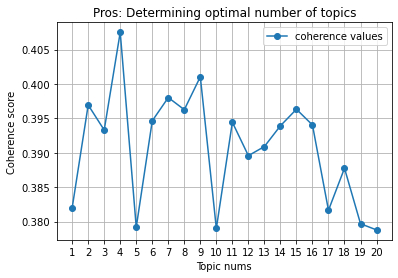

In [34]:
lines = plt.plot(topics_num, Coherence_Score)
plt.setp(lines, marker = "o") 
plt.grid(True)
plt.title("Pros: Determining optimal number of topics") 
plt.xlabel("Topic nums")
plt.ylabel("Coherence score")
plt.legend(["coherence values"], loc='best')
plt.xticks(topics_num)
plt.show()

In [93]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

  0%|                                                                                          | 0/540 [30:25<?, ?it/s]

 24%|██████████████████▍                                                           | 128/540 [30:52<1:40:52, 14.69s/it]


 48%|████████████████████████████████████▌                                       | 260/540 [1:01:52<1:05:27, 14.03s/it]


 73%|████████████████████████████████████████████████████████▌                     | 392/540 [1:33:48<35:07, 14.24s/it]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 524/540 [2:06:20<03:59, 14.98s/it]


100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [2:10:13<00:00, 14.47s/it]


In [35]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.91,
                                           eta=0.91)

C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.004*"zoom" + 0.004*"host" + 0.003*"easy" + 0.003*"meeting" + '
  '0.003*"group" + 0.003*"feature" + 0.003*"use" + 0.002*"reaction" + '
  '0.002*"allow" + 0.002*"chat"'),
 (1,
  '0.004*"zoom" + 0.003*"easy" + 0.002*"meeting" + 0.001*"video" + 0.001*"use" '
  '+ 0.001*"feature" + 0.001*"work" + 0.001*"software" + 0.001*"user" + '
  '0.001*"great"'),
 (2,
  '0.008*"student" + 0.006*"zoom" + 0.006*"teacher" + 0.004*"class" + '
  '0.004*"software" + 0.003*"face" + 0.003*"teach" + 0.003*"learn" + '
  '0.002*"use" + 0.002*"school"'),
 (3,
  '0.036*"zoom" + 0.034*"meeting" + 0.020*"easy" + 0.017*"feature" + '
  '0.016*"video" + 0.013*"screen" + 0.012*"share" + 0.011*"also" + '
  '0.011*"software" + 0.011*"use"'),
 (4,
  '0.003*"zoom" + 0.003*"easy" + 0.002*"meeting" + 0.001*"video" + '
  '0.001*"feature" + 0.001*"software" + 0.001*"work" + 0.001*"great" + '
  '0.001*"use" + 0.001*"screen"'),
 (5,
  '0.004*"meeting" + 0.003*"zoom" + 0.003*"easy" + 0.002*"keep" + '
  '0.002*"opportunit

C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.36378294852872695


In [114]:
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.183433  0.000548       1        1  71.340992
8     -0.008453 -0.013816       2        1   5.298651
2      0.013261  0.016711       3        1   4.206442
0      0.011204  0.002529       4        1   3.436912
5      0.031109 -0.001798       5        1   3.398365
6      0.018849  0.002244       6        1   3.342570
7      0.041380 -0.002129       7        1   3.055659
1      0.035391 -0.001912       8        1   2.963721
4      0.040692 -0.002378       9        1   2.956688, topic_info=         Term        Freq       Total Category  logprob  loglift
43       zoom  905.000000  905.000000  Default  30.0000  30.0000
421   student   63.000000   63.000000  Default  29.0000  29.0000
125      host  101.000000  101.000000  Default  28.0000  28.0000
5        easy  509.000000  509.000000  Default  27.0000  27.0000
33   software  277.000000  277.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
99       time    0.705888  181.507761   Topic9  -7.2359  -2.0285
57        get    0.659232  104.938645   Topic9  -7.3043  -1.5490
411      need    0.674715  137.151131   Topic9  -7.2811  -1.7934
186      even    0.660484  147.856703   Topic9  -7.3024  -1.8899
2        chat    0.659307  176.704901   Topic9  -7.3042  -2.0699

[597 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
233       1  0.945155  able
233       2  0.008833  able
233       3  0.008833  able
233       4  0.008833  able
233       5  0.008833  able
...     ...       ...   ...
43        5  0.004415  zoom
43        6  0.007727  zoom
43        7  0.003311  zoom
43        8  0.004415  zoom
43        9  0.003311  zoom

[1249 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 3, 1, 6, 7, 8, 2, 5])